In this notebook we will carry out rough offfline analysis.

This will include plotting the eddy kinetic energy, structural similarity scores,
and the r2 score. We also compare the distribution of true and predicted EKE.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cmocean
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns

In [22]:
directory = '/home/users/twilder/Python/AI4PEX/machine_learning/predictions/'
filename = 'eddy_energy_tendency_20260205-145855_SO_JET.nc'
ds = xr.open_dataset(directory + filename)
ds

<xarray.Dataset> Size: 7MB
Dimensions:       (time_counter: 359, y: 40, x: 40, var: 1)
Coordinates:
  * time_counter  (time_counter) object 3kB 0072-01-03 00:00:00 ... 0073-01-0...
    gphit         (y, x) float64 13kB ...
    glamt         (y, x) float64 13kB ...
  * var           (var) <U18 72B 'eke_tendency_asinh'
Dimensions without coordinates: y, x
Data variables:
    fine_ke_pred  (time_counter, y, x, var) float32 2MB ...
    fine_ke_true  (time_counter, y, x, var) float64 5MB ...
Attributes:
    Title:        Fine kinetic energy tendency - predicted and truth
    Description:  Predicted fine kinetic energy tendency from coarse-grained ...
    Units:        m^2/s^3
    Source:       training/cnn_20260205-145855.keras

Looking at the spatial pattern of true vs predicted EKE tendency

Text(0, 0.5, 'Latitude [degrees_north]')

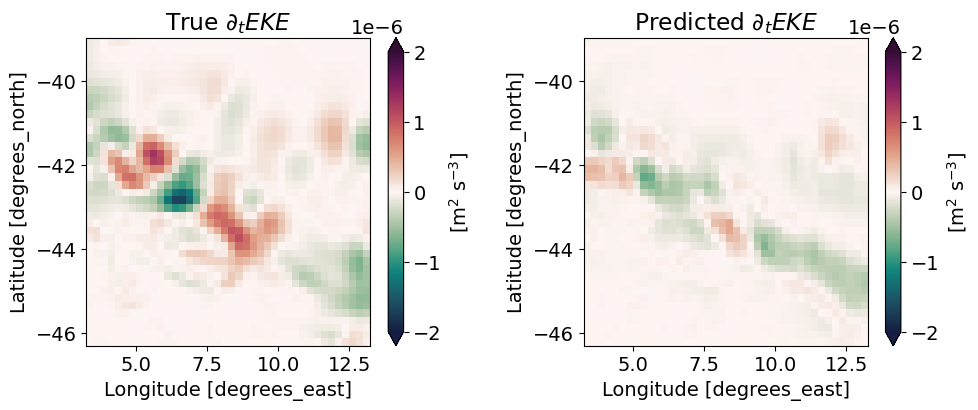

In [24]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(11, 4))
gs = fig.add_gridspec(1, 2, wspace=0.4)
axs = gs.subplots()

ds.fine_ke_true.isel(time_counter=0).plot(
    ax=axs[0],
    vmin=-2e-6, vmax=2e-6,
    x='glamt', y='gphit',
    cmap=cmocean.cm.curl,
    cbar_kwargs={'label': '[m$^2$ s$^{-3}$]'},
    extend='both')
axs[0].set_title('True $\partial_t EKE$')

ds.fine_ke_pred.isel(time_counter=0).plot(
    ax=axs[1],
    vmin=-2e-6, vmax=2e-6,
    x='glamt', y='gphit',
    cmap=cmocean.cm.curl,
    cbar_kwargs={'label': '[m$^2$ s$^{-3}$]'},
    extend='both')
axs[1].set_title('Predicted $\partial_t EKE$')
axs[1].set_xlabel('Longitude [degrees_east]')
axs[1].set_ylabel('Latitude [degrees_north]')

# plt.savefig(f"../DINO/Figures/true_vs_predicted_eke_tendency.png", dpi=300, bbox_inches='tight')

Calculated MSE, SSIM score, and R2 score

In [20]:
mse_value = mse(ds.fine_ke_true.isel(time_counter=100, var=0).to_numpy(), 
                         ds.fine_ke_pred.isel(time_counter=100, var=0).to_numpy())
mse_value

0.003202610296031304

In [13]:
ssim_pred = ssim(ds.fine_ke_true.isel(time_counter=0, var=0).to_numpy(), 
                 ds.fine_ke_pred.isel(time_counter=0, var=0).to_numpy(),
                 data_range = ds.fine_ke_pred.isel(time_counter=0, var=0).max().values-\
                 ds.fine_ke_pred.isel(time_counter=0, var=0).min().values,
                )
ssim_pred

np.float64(0.7890844427568159)

SSIM and R2 score for all 30 days

In [25]:
r2 = np.zeros(ds.time_counter.size)
ssim_pred = np.zeros(ds.time_counter.size)

for i in range(ds.time_counter.size):

    # mean of observed data
    yt_mean = ds.fine_ke_true.isel(time_counter=i).mean(dim=['x', 'y'])
    
    # sum of squares of residuals
    ss_res = ((ds.fine_ke_true.isel(time_counter=i)-ds.fine_ke_pred.isel(time_counter=i))**2).sum(dim=['x', 'y'])
    ss_res
    
    # total sum of squares
    ss_tot = ((ds.fine_ke_true.isel(time_counter=i)-yt_mean)**2).sum(dim=['x', 'y'])
    ss_tot
    
    # coefficient of determination
    r2[i] = 1- ss_res/ss_tot
    r2[i]

    # now ssim score
    ssim_pred[i] = ssim(ds.fine_ke_true.isel(time_counter=i, var=0).to_numpy(), 
                 ds.fine_ke_pred.isel(time_counter=i, var=0).to_numpy(),
                 data_range = ds.fine_ke_pred.isel(time_counter=i, var=0).max().values-\
                        ds.fine_ke_pred.isel(time_counter=i, var=0).min().values,
                )

In [26]:
r2, ssim_pred

(array([ 1.43248672e-01,  5.31850405e-02, -1.67831552e-01, -3.62364040e-01,
        -5.53604954e-02,  1.48174126e-01,  2.08127962e-01,  9.16173162e-02,
         4.02548355e-02,  1.06466864e-01,  1.18814432e-01,  3.31862150e-02,
        -2.20020258e-01,  1.51890075e-01,  7.85597906e-03, -8.73307546e-02,
        -1.37071398e-01,  2.46750475e-02,  1.96276082e-01,  3.66172248e-01,
         2.73691399e-01,  1.64960324e-01, -2.25895325e-01, -4.27417760e-01,
        -8.49778302e-02,  2.00867687e-01,  2.84437527e-01,  7.13881127e-02,
        -1.96106163e-01, -6.39551654e-02,  1.57909935e-02, -2.99426977e-02,
         1.19038021e-02, -6.41141310e-02, -2.69618298e-02,  1.12777920e-01,
         2.10371966e-01,  4.58473383e-01,  4.15689230e-01,  2.73881675e-01,
         1.68663873e-01,  1.22325631e-01,  7.42315409e-02,  1.69901545e-03,
         1.12046977e-01,  2.24455749e-01,  2.53282829e-01,  1.70246245e-01,
         3.15590160e-01,  3.60100021e-01,  1.76195345e-01,  4.74048189e-02,
         2.8

Save the scores to compare models. Here we compare the models trained on 720 and 3600 data samples. Validation and testing are the same in each.

In [13]:
directory = 'data/'

np.save(directory + 'r2score_20260205-135720_SO_JET.npy', r2)
np.save(directory + 'ssimscore_20260205-135720_SO_JET.npy', ssim_pred)

Now load in scores, plot and compare

In [14]:
r2_eke = np.load(directory + 'r2score_20260205-135720_SO_JET.npy', allow_pickle=True)
# r2 = np.load(directory + 'r2score_20260122-152652_SO_JET.npy', allow_pickle=True)
# r2_3600 = np.load(directory + 'r2score_20260122-200446_SO_JET.npy', allow_pickle=True)

ssim_eke = np.load(directory + 'ssimscore_20260205-135720_SO_JET.npy', allow_pickle=True)
# ssim = np.load(directory + 'ssimscore_20260122-152652_SO_JET.npy', allow_pickle=True)
# ssim_3600 = np.load(directory + 'ssimscore_20260122-200446_SO_JET.npy', allow_pickle=True)

In [18]:
# Mean scores
r2_720.mean(), r2_3600.mean(), ssim_720.mean(), ssim_3600.mean()

(np.float64(0.848794176759919),
 np.float64(0.8155678985284353),
 np.float64(0.8487460212441773),
 np.float64(0.8509978011629487))

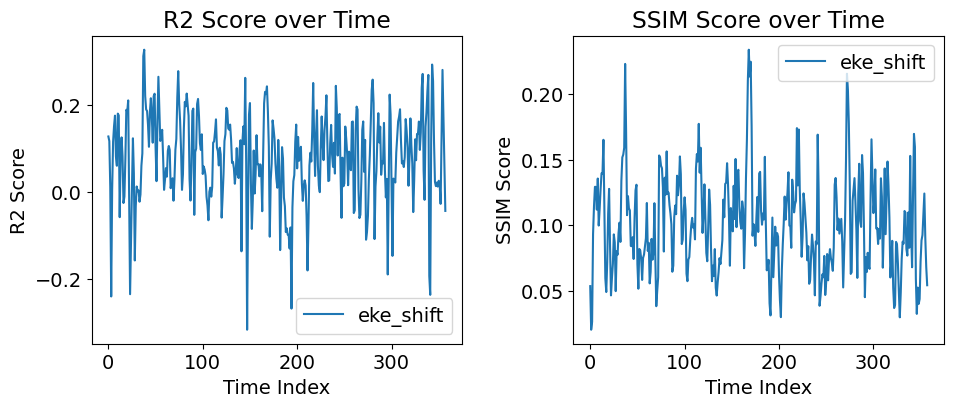

In [15]:
fig = plt.figure(figsize=(11, 4))
gs = fig.add_gridspec(1, 2, wspace=0.3)
axs = gs.subplots()

axs[0].plot(r2_eke[:-1], label='eke_shift')
# axs[0].plot(r2[:-1], label='original')
# axs[0].plot(r2_3600, label='3600')
axs[0].set_title('R2 Score over Time')
axs[0].set_xlabel('Time Index')
axs[0].set_ylabel('R2 Score')
axs[0].legend() 


axs[1].plot(ssim_eke[:-1], label='eke_shift')
# axs[1].plot(ssim[:-1], label='original')
# axs[1].plot(ssim_3600, label='3600')
axs[1].set_title('SSIM Score over Time')
axs[1].set_xlabel('Time Index')
axs[1].set_ylabel('SSIM Score')
axs[1].legend() 

Look at EKE distributions

In [27]:
df = ds.to_dataframe()
df

fine_ke_pred  fine_ke_true  \
time_counter        y  x  var                                              
0072-01-03 00:00:00 0  0  eke_tendency_asinh -4.978320e-09 -1.038513e-08   
                       1  eke_tendency_asinh  3.941189e-09 -1.887224e-08   
                       2  eke_tendency_asinh -2.176882e-09 -1.710169e-08   
                       3  eke_tendency_asinh -4.928698e-09 -3.956067e-09   
                       4  eke_tendency_asinh -5.195790e-09 -4.262481e-09   
...                                                    ...           ...   
0073-01-01 00:00:00 39 35 eke_tendency_asinh  5.576047e-07  2.395399e-09   
                       36 eke_tendency_asinh  7.106543e-07  2.537797e-09   
                       37 eke_tendency_asinh  7.837855e-07  1.579623e-11   
                       38 eke_tendency_asinh  7.195865e-07 -8.317354e-09   
                       39 eke_tendency_asinh  7.721487e-07 -1.599856e-08   

                                                  gphit   glamt  
time_counter        y  x  var                                    
0072-01-03 00:00:00 0  0  eke_tendency_asinh -46.224777   3.375  
                       1  eke_tendency_asinh -46.224777   3.625  
                       2  eke_tendency_asinh -46.224777   3.875  
                       3  eke_tendency_asinh -46.224777   4.125  
                       4  eke_tendency_asinh -46.224777   4.375  
...                                                 ...     ...  
0073-01-01 00:00:00 39 35 eke_tendency_asinh -39.065640  12.125  
                       36 eke_tendency_asinh -39.065640  12.375  
                       37 eke_tendency_asinh -39.065640  12.625  
                       38 eke_tendency_asinh -39.065640  12.875  
                       39 eke_tendency_asinh -39.065640  13.125  

[574400 rows x 4 columns]

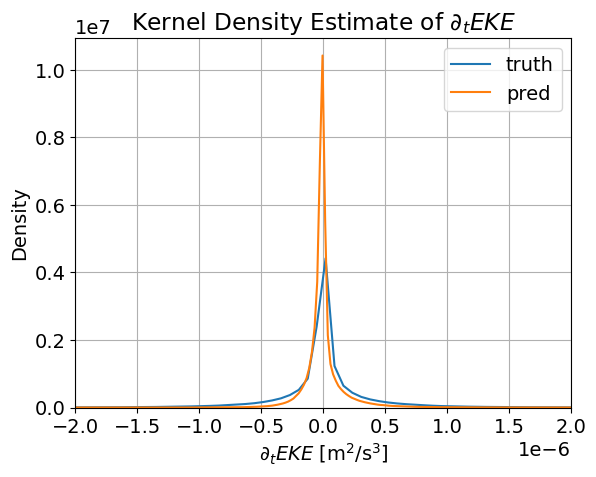

In [31]:
sns.kdeplot(df['fine_ke_true'], label='truth', cut=0)
sns.kdeplot(df['fine_ke_pred'], label='pred', cut=0)
plt.title('Kernel Density Estimate of $\partial_t EKE$')
plt.xlabel('$\partial_t EKE$ [m$^2$/s$^{3}$]')
plt.ylabel('Density')
plt.legend()
plt.xlim(-2e-6, 2e-6)
plt.grid()
# plt.savefig('Figures/kde_eke_preproc.png', bbox_inches='tight', dpi=100)

(-0.25, 2.5)

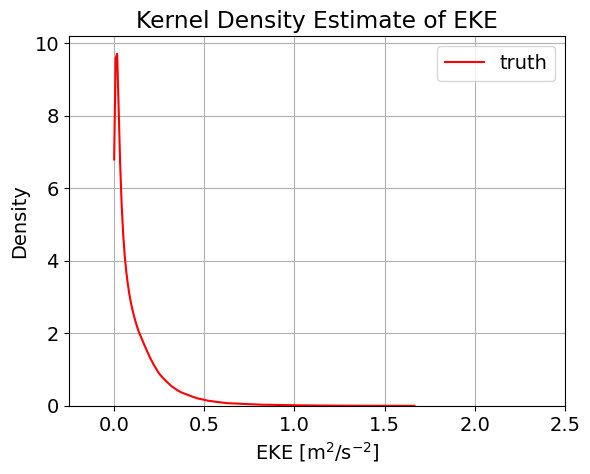

In [15]:
sns.kdeplot(df['fine_ke_true'], label='truth', cut=0, color='r')
# sns.kdeplot(df['fine_ke_pred'], label='pred', cut=0)
plt.title('Kernel Density Estimate of EKE')
plt.xlabel('EKE [m$^2$/s$^{-2}$]')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.xlim(-0.25, 2.5)

Compare distribution of input vs output

In [2]:
directory = '/home/users/twilder/Python/AI4PEX/machine_learning/predictions/'
filename = 'eddy_energy_20260122-152652_SO_JET.nc'
ds_out = xr.open_dataset(directory + filename)
ds_out

<xarray.Dataset> Size: 7MB
Dimensions:       (time_counter: 360, y: 40, x: 40, var: 1)
Coordinates:
  * time_counter  (time_counter) object 3kB 0072-01-02 00:00:00 ... 0073-01-0...
    gphit         (y, x) float64 13kB ...
    glamt         (y, x) float64 13kB ...
  * var           (var) <U7 28B 'eke_log'
Dimensions without coordinates: y, x
Data variables:
    fine_ke_pred  (time_counter, y, x, var) float32 2MB ...
    fine_ke_true  (time_counter, y, x, var) float64 5MB ...
Attributes:
    Title:        Fine kinetic energy - predicted and truth (region IO)
    Description:  Predicted fine kinetic energy from coarse-grained data usin...
    Units:        m^2/s^2
    Source:       training/cnn_20260122-152652.keras

In [3]:
directory = '/gws/nopw/j04/ai4pex/twilder/NEMO_data/DINO/EXP16/features/SO_JET/coarsened_data/'
fn = 'MINT_1d_0061-0072_eke_c_SO_JET.nc'
ds_in = xr.open_dataset(directory + fn)
ds_in

<xarray.Dataset> Size: 112MB
Dimensions:  (t: 4320, y_c: 54, x_c: 60)
Coordinates:
  * t        (t) object 35kB 0061-01-02 00:00:00 ... 0073-01-01 00:00:00
    gphit    (y_c, x_c) float64 26kB ...
    glamt    (y_c, x_c) float64 26kB ...
Dimensions without coordinates: y_c, x_c
Data variables:
    eke      (t, y_c, x_c) float64 112MB ...
Attributes:
    description:  DINO EXP16 regridded to EXP4 -> ocean T grid variables

In [4]:
df_out = ds_out.to_dataframe()
df_in = ds_in.to_dataframe()
df_out, df_in

(                                   fine_ke_pred  fine_ke_true      gphit  \
 time_counter        y  x  var                                              
 0072-01-02 00:00:00 0  0  eke_log      0.007654      0.006764 -46.224777   
                        1  eke_log      0.010357      0.010470 -46.224777   
                        2  eke_log      0.008936      0.008071 -46.224777   
                        3  eke_log      0.008579      0.005946 -46.224777   
                        4  eke_log      0.006076      0.006336 -46.224777   
 ...                                         ...           ...        ...   
 0073-01-01 00:00:00 39 35 eke_log      0.014666      0.008573 -39.065640   
                        36 eke_log      0.008809      0.010024 -39.065640   
                        37 eke_log      0.010522      0.011289 -39.065640   
                        38 eke_log      0.011715      0.011320 -39.065640   
                        39 eke_log      0.011628      0.009702 -39.065640   

(-0.25, 2.5)

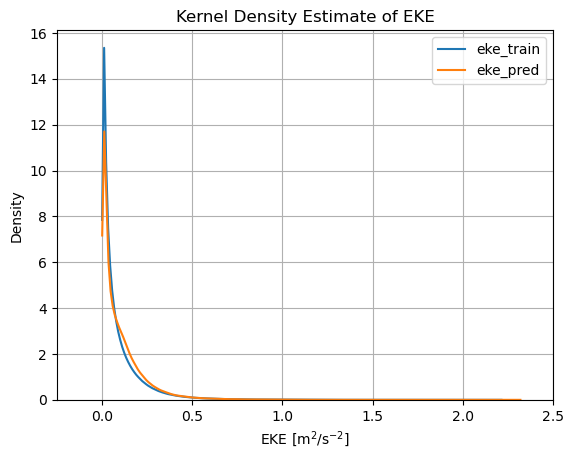

In [6]:
sns.kdeplot(df_in['eke'], label='eke_train', cut=0)
sns.kdeplot(df_out['fine_ke_pred'], label='eke_pred', cut=0)
plt.title('Kernel Density Estimate of EKE')
plt.xlabel('EKE [m$^2$/s$^{-2}$]')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.xlim(-0.25, 2.5)

### Compare target with input features